# **Imports**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from keras.preprocessing.image import ImageDataGenerator
from prettytable import PrettyTable

In [2]:
import tensorflow as tf
import tensorflow_hub as hub

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization, Conv2D, ReLU
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import MobileNet

In [3]:
import tensorflow as tf 
device_name = tf.test.gpu_device_name()
if len(device_name) > 0:
    print("Found GPU at: {}".format(device_name))
else:
    device_name = "/device:CPU:0"
    print("No GPU, using {}.".format(device_name))

Found GPU at: /device:GPU:0


# **Data**

In [4]:
mainDIR = os.listdir('/content/drive/MyDrive/chest_xray 3c [AUG + NOISE] (splited .85 .075 .075)')
print(mainDIR)

['val', 'test', 'train']


In [5]:
train_folder= '/content/drive/MyDrive/chest_xray 3c [AUG + NOISE] (splited .85 .075 .075)/train'
val_folder = '/content/drive/MyDrive/chest_xray 3c [AUG + NOISE] (splited .85 .075 .075)/val'
test_folder = '/content/drive/MyDrive/chest_xray 3c [AUG + NOISE] (splited .85 .075 .075)/test'

In [ ]:
from prettytable import PrettyTable
# statestics after spliting the dataset and adding noise
# stats train
num_train_normal = len(os.listdir('/content/drive/MyDrive/chest_xray 3c [AUG + NOISE] (splited .85 .075 .075)/train/Normal'))
num_train_bacterial = len(os.listdir('/content/drive/MyDrive/chest_xray 3c [AUG + NOISE] (splited .85 .075 .075)/train/Bacterial'))
num_train_viral = len(os.listdir('/content/drive/MyDrive/chest_xray 3c [AUG + NOISE] (splited .85 .075 .075)/train/Viral'))
TOT_train = num_train_normal + num_train_bacterial + num_train_viral
# stats test
num_test_normal = len(os.listdir('/content/drive/MyDrive/chest_xray 3c [AUG + NOISE] (splited .85 .075 .075)/test/Normal'))
num_test_bacterial = len(os.listdir('/content/drive/MyDrive/chest_xray 3c [AUG + NOISE] (splited .85 .075 .075)/test/Bacterial'))
num_test_viral = len(os.listdir('/content/drive/MyDrive/chest_xray 3c [AUG + NOISE] (splited .85 .075 .075)/test/Viral'))
TOT_test = num_test_viral + num_test_bacterial + num_test_normal
# stats valdidation
num_valid_normal = len(os.listdir('/content/drive/MyDrive/chest_xray 3c [AUG + NOISE] (splited .85 .075 .075)/val/Normal'))
num_valid_bacterial = len(os.listdir('/content/drive/MyDrive/chest_xray 3c [AUG + NOISE] (splited .85 .075 .075)/val/Bacterial'))
num_valid_viral = len(os.listdir('/content/drive/MyDrive/chest_xray 3c [AUG + NOISE] (splited .85 .075 .075)/val/Viral'))
TOT_valid = num_valid_normal + num_valid_bacterial + num_valid_viral

TOT_normal =  num_valid_normal + num_test_normal + num_train_normal
TOT_viral = num_valid_viral + num_test_viral + num_train_viral
TOT_bacterial = num_train_bacterial + num_test_bacterial + num_valid_bacterial
TOT_all = TOT_normal + TOT_viral +TOT_bacterial

#table stat general
t = PrettyTable(['Class','Train','Validation', 'Test','Total'])
t.add_row(['Normal',num_train_normal,num_valid_normal,num_test_normal,TOT_normal])
t.add_row(['viral',num_train_viral,num_valid_viral,num_test_viral,TOT_viral])
t.add_row(['Bacterial',num_train_bacterial,num_valid_bacterial,num_test_bacterial,TOT_bacterial])
t.add_row(['Total',TOT_train,TOT_valid,TOT_test,TOT_all])
print(t)

+-----------+-------+------------+------+-------+
|   Class   | Train | Validation | Test | Total |
+-----------+-------+------------+------+-------+
|   Normal  |  1614 |    118     | 120  |  1852 |
|   viral   |  3045 |    111     | 113  |  3269 |
| Bacterial |  2835 |    208     | 209  |  3252 |
|   Total   |  7494 |    437     | 442  |  8373 |
+-----------+-------+------------+------+-------+


In [6]:
def claheImage(img): #Nada
    # convert image to LAB color space
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    gray = cv2.convertScaleAbs(gray)
    # apply CLAHE to the L channel
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl = clahe.apply(gray)

    # convert the LAB image back to RGB color space
    final = cv2.cvtColor(cl, cv2.COLOR_GRAY2BGR)
    cl_img = np.float64(final)
    return cl_img

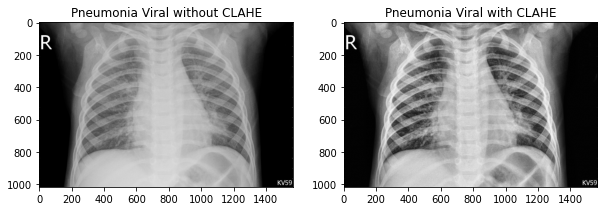

In [ ]:
#plot Pneumonia Viral image with/without CLAHE
fig = plt.figure(figsize=(10, 10))
columns = 2 
rows = 1
fig.add_subplot(rows, columns, 1)
plt.title('Pneumonia Viral without CLAHE')
plt.imshow(cv2.imread('/content/drive/MyDrive/chest_xray 3 classes (NOISY + aug viral)(splited .7 .15 .15)/train/Viral/person1080_virus_1791.jpeg')/255)

fig.add_subplot(rows, columns, 2)
plt.title('Pneumonia Viral with CLAHE')
plt.imshow(claheImage(cv2.imread('/content/drive/MyDrive/chest_xray 3 classes (NOISY + aug viral)(splited .7 .15 .15)/train/Viral/person1080_virus_1791.jpeg'))/255)
plt.show()

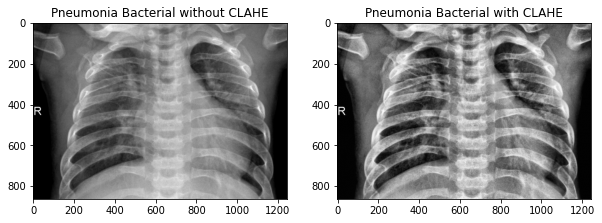

In [ ]:
#plot Pneumonia Bacterial image with/without CLAHE
fig = plt.figure(figsize=(10, 10))
columns = 2 
rows = 1
fig.add_subplot(rows, columns, 1)
plt.title('Pneumonia Bacterial without CLAHE')
plt.imshow(cv2.imread('/content/drive/MyDrive/chest_xray 3 classes (NOISY + aug viral)(splited .7 .15 .15)/train/Bacterial/person1001_bacteria_2932.jpeg')/255)

fig.add_subplot(rows, columns, 2)
plt.title('Pneumonia Bacterial with CLAHE')
plt.imshow(claheImage(cv2.imread('/content/drive/MyDrive/chest_xray 3 classes (NOISY + aug viral)(splited .7 .15 .15)/train/Bacterial/person1001_bacteria_2932.jpeg'))/255)
plt.show()

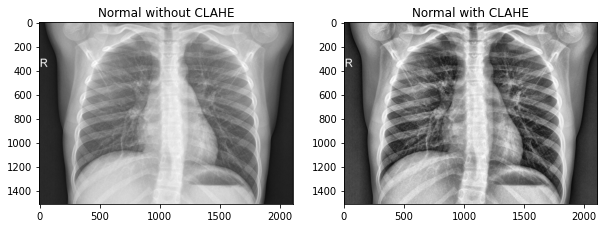

In [ ]:
#plot Normal image with/without CLAHE
fig = plt.figure(figsize=(10, 10))
columns = 2 
rows = 1
fig.add_subplot(rows, columns, 1)
plt.title('Normal without CLAHE')
plt.imshow(cv2.imread('/content/drive/MyDrive/chest_xray 3 classes (NOISY + aug viral)(splited .7 .15 .15)/train/Normal/IM-0003-0001.jpeg')/255)

fig.add_subplot(rows, columns, 2)
plt.title('Normal with CLAHE')
plt.imshow(claheImage(cv2.imread('/content/drive/MyDrive/chest_xray 3 classes (NOISY + aug viral)(splited .7 .15 .15)/train/Normal/IM-0003-0001.jpeg'))/255)
plt.show()

# **Model**

In [7]:
# data gens
with tf.device(device_name):
  train_datagen = ImageDataGenerator(rescale = 1./255,
                                    rotation_range=10,
                                    shear_range = 20,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    preprocessing_function = claheImage
                                    )

  test_datagen = ImageDataGenerator(rescale = 1./255, preprocessing_function = claheImage)  #Image normalization.
  val_datagen = ImageDataGenerator(rescale = 1./255, preprocessing_function = claheImage)  #Image normalization.

  training_set = train_datagen.flow_from_directory(train_folder,
                                                  target_size = (224, 224),
                                                  batch_size = 16,
                                                  class_mode = 'categorical'
                                                  )

  validation_set = val_datagen.flow_from_directory(val_folder,
                                                      target_size=(224, 224),
                                                      batch_size=16,
                                                      class_mode='categorical'
                                                      )

  test_set = test_datagen.flow_from_directory(test_folder,
                                              target_size = (224, 224),
                                              class_mode = 'categorical',
                                              batch_size = 1,
                                              shuffle = False)

Found 7494 images belonging to 3 classes.
Found 437 images belonging to 3 classes.
Found 442 images belonging to 3 classes.


In [ ]:
with tf.device(device_name):
  # Load the pre-trained MobileNet model without the top layer
  base_model = MobileNet(weights='imagenet', include_top=True, input_shape=(224, 224, 3))

In [ ]:
with tf.device(device_name):
  number_of_layers = len(base_model.layers)

In [ ]:
# Freeze the % layers in the base model
percent = 0.25
number_of_layers_to_freeze =  int(number_of_layers * percent)
with tf.device(device_name):
  # Freeze some layers
  for layer in base_model.layers[:number_of_layers_to_freeze]:
      layer.trainable = False

In [ ]:
# description of the model
with tf.device(device_name):
  model = Sequential()
  model.add(base_model)
  model.add(GlobalAveragePooling2D())
  model.add(BatchNormalization())
  model.add(Dropout(0.2))
  model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.01)))
  model.add(BatchNormalization())
  model.add(Dropout(0.2))
  model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.01)))
  model.add(Dense(2, activation='softmax'))

In [ ]:
with tf.device(device_name):
  model.compile(
    optimizer="adam",
    loss='categorical_crossentropy',
    metrics=['acc'])

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 global_average_pooling2d_3   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 batch_normalization_8 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dropout_8 (Dropout)         (None, 512)               0         
                                                                 
 dense_12 (Dense)            (None, 512)               262656    
                                                                 
 batch_normalization_9 (Batc  (None, 512)             

In [ ]:
# callbacks
from tensorflow.keras import callbacks
with tf.device(device_name):
  early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    min_delta=1e-7,
    restore_best_weights=True,
)

  plateau = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor = 0.2,                                     
    patience = 2,                                   
    min_delt = 1e-7,                                
    cooldown = 0,                               
    verbose = 1
) 

  checkpoint = callbacks.ModelCheckpoint(
    '/content/drive/MyDrive/models (3 calsses chest_xray)/Model 27-03 (mobilenet mod 2)/best_model.h5', 
    monitor='val_loss', 
    save_best_only=True, 
    mode='min', verbose=1
)

In [ ]:
# train
with tf.device(device_name):
  history = model.fit(training_set,validation_data = validation_set,epochs=50,batch_size = 16,
                      steps_per_epoch=(7494 /16),
                      validation_steps=(437 /16),
                      callbacks=[early_stopping, plateau,checkpoint])

Epoch 1/50
469/468 [==============================] - ETA: 0s - loss: 2.0482 - acc: 0.4486
Epoch 1: val_loss improved from inf to 1.88365, saving model to /content/drive/MyDrive/models (3 calsses chest_xray)/Vgg19 try/best_model2.h5
468/468 [==============================] - 239s 493ms/step - loss: 2.0482 - acc: 0.4486 - val_loss: 1.8836 - val_acc: 0.3913 - lr: 0.0010
Epoch 2/50
469/468 [==============================] - ETA: 0s - loss: 1.4712 - acc: 0.5224
Epoch 2: val_loss improved from 1.88365 to 1.21506, saving model to /content/drive/MyDrive/models (3 calsses chest_xray)/Vgg19 try/best_model2.h5
468/468 [==============================] - 240s 513ms/step - loss: 1.4712 - acc: 0.5224 - val_loss: 1.2151 - val_acc: 0.6979 - lr: 0.0010
Epoch 3/50
469/468 [==============================] - ETA: 0s - loss: 1.2762 - acc: 0.5514
Epoch 3: val_loss did not improve from 1.21506
468/468 [==============================] - 226s 482ms/step - loss: 1.2762 - acc: 0.5514 - val_loss: 2.6050 - val_acc

KeyboardInterrupt: ignored

In [ ]:
import pickle
# sauvgarder le model
model.save('/content/drive/MyDrive/models (3 calsses chest_xray)/Model 27-03 (mobilenet mod 2)/last_epoch_model.h5')
# save history
with open('/content/drive/MyDrive/models (3 calsses chest_xray)/Model 27-03 (mobilenet mod 2)/history.pkl', 'wb') as file:
    pickle.dump(history.history, file)



*   Learning Curve (Loss)




In [8]:
import seaborn as sns

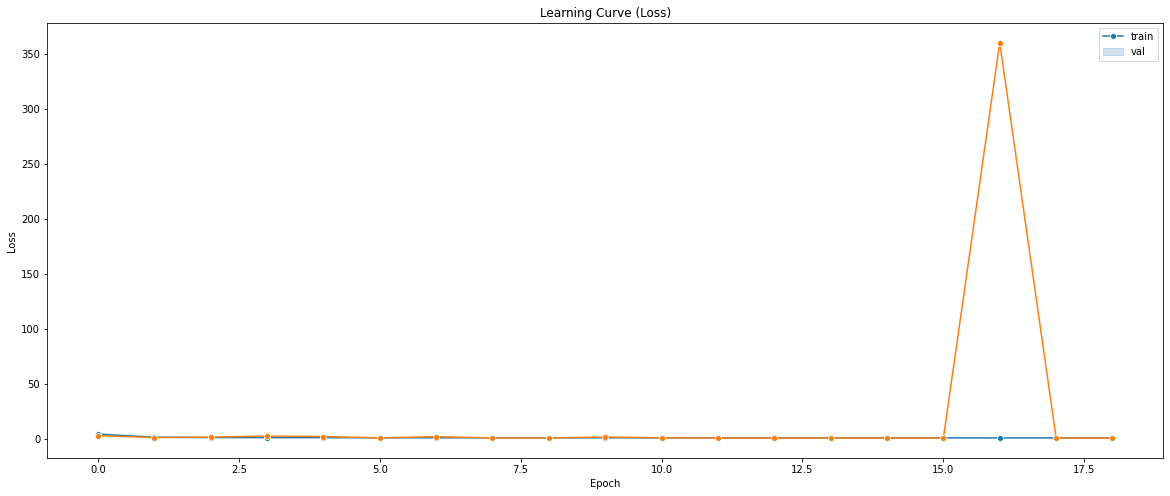

In [ ]:
# Learning Curve (Loss)
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history.epoch, y = history.history['loss'],  marker="o")
sns.lineplot(x = history.epoch, y = history.history['val_loss'], marker="o")
ax.set_title('Learning Curve (Loss)')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.legend(['train', 'val'], loc='best')
plt.savefig('/content/drive/MyDrive/models (3 calsses chest_xray)/Model 27-03 (mobilenet mod 2)/Learning Curve (Loss).png')
plt.show()

*   Learning Curve (Accuracy)

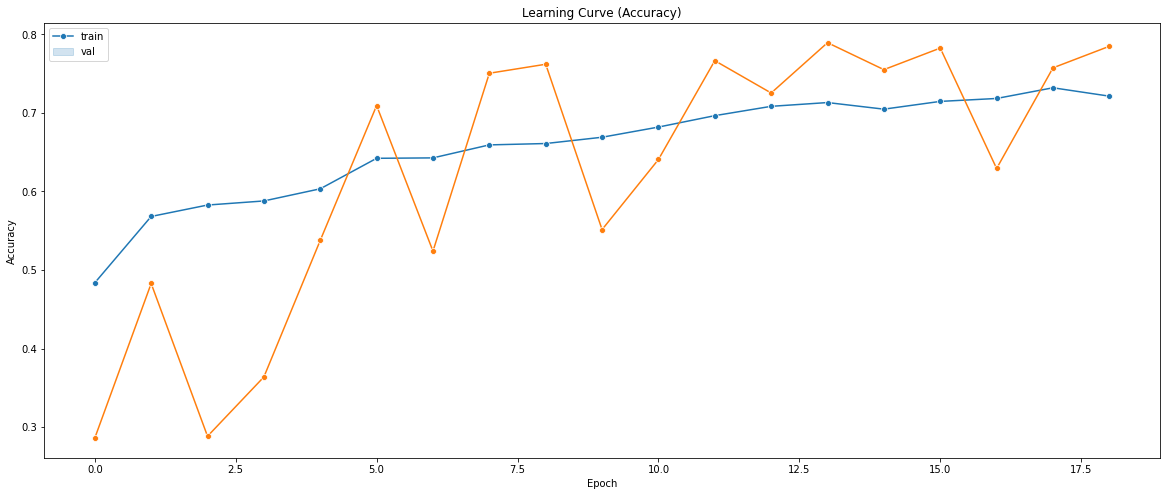

In [ ]:
# Learning Curve (Accuracy)
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history.epoch, y = history.history['acc'],marker="o")
sns.lineplot(x = history.epoch, y = history.history['val_acc'],marker="o")
ax.set_title('Learning Curve (Accuracy)')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.legend(['train', 'val'], loc='best')
plt.savefig('/content/drive/MyDrive/models (3 calsses chest_xray)/Model 27-03 (mobilenet mod 2)/Learning Curve (Accuracy).png')
plt.show()

# **Performance Metrics**

In [9]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve ,auc

In [10]:
#load best model
model = tf.keras.models.load_model('/content/drive/MyDrive/models (3 calsses chest_xray)/Model 24-03 (.85 aug + noise 16b + weighted 2-1-5)/best_model.h5')

In [11]:
import pickle
# load the saved model from file
with open('/content/drive/MyDrive/models (3 calsses chest_xray)/Model 24-03 (.85 aug + noise 16b + weighted 2-1-5)/history.pkl', 'rb') as file:
    hist = pickle.load(file)

# access the history attribute of the model
index_of_min = np.argmin(hist['val_loss']) # min val loss
loss = hist['loss'][index_of_min]
val_loss = hist['val_loss'][index_of_min]
acc = hist['acc'][index_of_min]
val_acc = hist['val_acc'][index_of_min]
print('---------------------best_model-----------------------')
print('acc: '+"{:0.4f}".format(acc))
print('loss: '+"{:0.4f}".format(loss))
print('val_acc: '+"{:0.4f}".format(val_acc))
print('val_loss: '+"{:0.4f}".format(val_loss))

index_last_epoch = len(hist['loss']) - 1 
loss = hist['loss'][index_last_epoch]
val_loss = hist['val_loss'][index_last_epoch]
acc = hist['acc'][index_last_epoch]
val_acc = hist['val_acc'][index_last_epoch]

print('---------------------last_epoch_model-----------------------')
print('acc: '+"{:0.4f}".format(acc))
print('loss: '+"{:0.4f}".format(loss))
print('val_acc: '+"{:0.4f}".format(val_acc))
print('val_loss: '+"{:0.4f}".format(val_loss))

---------------------best_model-----------------------
acc: 0.8726
loss: 0.8352
val_acc: 0.8467
val_loss: 0.4621
---------------------last_epoch_model-----------------------
acc: 0.8824
loss: 0.7461
val_acc: 0.8444
val_loss: 0.4813




*   Test evaluation



In [ ]:
# test evaluation
with tf.device(device_name):
  test_loss, test_acc = model.evaluate(test_set)
  print('Test accuracy:', test_acc)
  print('Test loss:', test_loss)

442/442 [==============================] - 74s 145ms/step - loss: 0.3966 - acc: 0.8597
Test accuracy: 0.8597285151481628
Test loss: 0.3966485857963562




*   Confusion matrix



In [ ]:
with tf.device(device_name):
  test_set.reset()
  Y_pred = model.predict(test_set)
  y_pred = np.argmax(Y_pred, axis=1)

442/442 [==============================] - 8s 18ms/step


In [ ]:
confusion_matrix_res  = confusion_matrix(test_set.classes, y_pred)

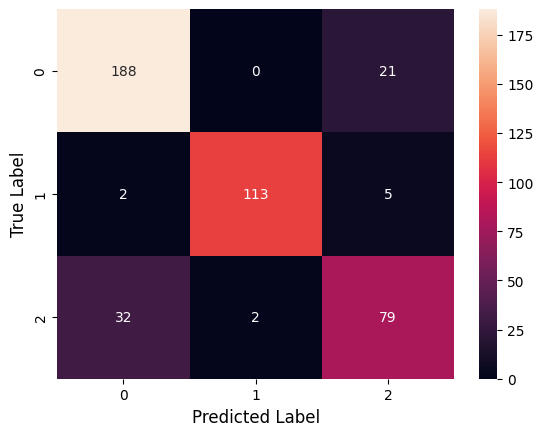

In [ ]:
sns.heatmap(confusion_matrix_res, annot=True, fmt="d")
plt.xlabel("Predicted Label", fontsize= 12)
plt.ylabel("True Label", fontsize= 12)
#plt.savefig('/content/drive/MyDrive/models (3 calsses chest_xray)/Vgg19 try/confusion_matrix_res2.png')
plt.show()

*   sensitivity & specificity

In [ ]:
def calculate_sen_spe(y_true, y_pred):
    TP = sum((y_true == 1) & (y_pred == 1))
    FN = sum((y_true == 1) & (y_pred == 0))
    TN = sum((y_true == 0) & (y_pred == 0))
    FP = sum((y_true == 0) & (y_pred == 1))

    sensitivity = TP / (TP + FN)
    specificity = TN / (TN + FP)
    
    return sensitivity, specificity

In [ ]:
sensitivity, specificity = calculate_sen_spe(test_set.classes, y_pred)
print('sensitivity: '+"{:0.4f}".format(sensitivity))
print('specificity: '+"{:0.4f}".format(specificity))

sensitivity: 0.9826
specificity: 1.0000




*   precision  -  recall - f1-score - support



In [ ]:
print(classification_report(test_set.classes, y_pred, labels = [0, 1,2],digits=4))

              precision    recall  f1-score   support

           0     0.8468    0.8995    0.8724       209
           1     0.9826    0.9417    0.9617       120
           2     0.7524    0.6991    0.7248       113

    accuracy                         0.8597       442
   macro avg     0.8606    0.8468    0.8530       442
weighted avg     0.8596    0.8597    0.8589       442





*  ROC Curve



In [ ]:
# Select the second column to obtain the predicted probabilities of the positive class
# fpr -> false positive rate tpr-> true positive rate
fpr, tpr, thresholds = roc_curve(test_set.classes, Y_pred[:,1])

# calculate the area under the ROC curve
roc_auc = auc(fpr, tpr)
print('ROC_AUC: ', roc_auc)

# plot the ROC curve
plt.subplots(figsize=(6,6))
plt.plot(fpr, tpr, color='darkorange', label = 'ROC_AUC = %0.4f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel("False Positive Rate", fontsize= 12)
plt.ylabel("True Positive Rate", fontsize= 12)
plt.legend(loc="lower right")
#plt.savefig('/content/drive/MyDrive/models (3 calsses chest_xray)/Vgg19 try/COURBE ROC avec AUC.png')
plt.show()

ValueError: ignored

# **CAM**

In [12]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
from keras.models import load_model
import matplotlib

In [13]:
# Find the last convolutional layer
layer = model.get_layer('mobilenet_1.00_224')

In [14]:
test_set[0][1]

array([[1., 0., 0.]], dtype=float32)

In [15]:
first_item_name = test_set.filenames[0]
print("The name of the first item in the dataset is:", first_item_name)

The name of the first item in the dataset is: Bacterial/person100_bacteria_478.jpeg


In [16]:
model.predict(test_set[0][0])

1/1 [==============================] - 8s 8s/step


array([[0.96134686, 0.00378605, 0.03486702]], dtype=float32)

In [17]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

In [85]:
img_ori = load_img('/content/drive/MyDrive/chest_xray 3c [AUG + NOISE] (splited .85 .075 .075)/test/Bacterial/person23_bacteria_95.jpeg', target_size=(224, 224))
# Convert the PIL object to a numpy array
img_array =claheImage( img_to_array(img_ori))
ressssss = img_to_array(img_ori)/255
# Reshape the array to add an extra dimension to represent the batch size
img_array = np.expand_dims(img_array, axis=0)

# Preprocess the image by rescaling its pixel values to the range [0, 1]
x1 = img_array / 255.

#/content/drive/MyDrive/Aug (close gap + noise) (splited .7 .15 .15)/val/Pneumonia/person1393_virus_2396.jpeg
#/content/drive/MyDrive/chest_xray 3c [AUG + NOISE] (splited .85 .075 .075)/val/Viral/person1089_virus_1808.jpeg

In [86]:
preds = model.predict(x1)
print(preds)
predicted_class = np.argmax(preds)
print(predicted_class)

1/1 [==============================] - 0s 32ms/step
[[9.9247169e-01 7.2586787e-04 6.8024583e-03]]
0


In [90]:
img_ori = claheImage(cv2.imread('/content/drive/MyDrive/chest_xray 3c [AUG + NOISE] (splited .85 .075 .075)/test/Bacterial/person5_bacteria_17.jpeg'))/255
img = cv2.resize(img_ori, (224,224))
x = keras.utils.img_to_array(img)
x = np.expand_dims(x, axis=0)
#/content/drive/MyDrive/Aug (close gap + noise) (splited .7 .15 .15)/val/Pneumonia/person1393_virus_2396.jpeg
#/content/drive/MyDrive/chest_xray 3c [AUG + NOISE] (splited .85 .075 .075)/val/Viral/person1089_virus_1808.jpeg

In [91]:
preds = model.predict(x)
print(preds)
predicted_class = np.argmax(preds)
print(predicted_class)

1/1 [==============================] - 0s 21ms/step
[[9.6567130e-01 3.0126801e-04 3.4027442e-02]]
0


1/1 [==============================] - 1s 1s/step


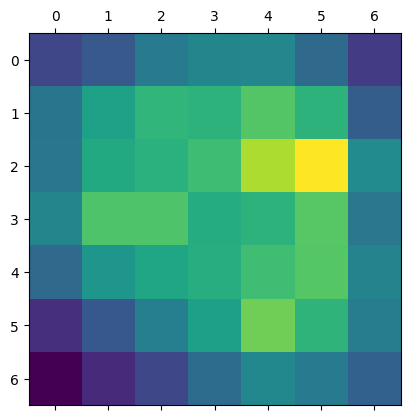

In [92]:
from google.colab.patches import cv2_imshow
new_model = tf.keras.models.Model(inputs=layer.input, outputs=[layer.get_layer('conv_pw_13').output])
# Get the final convolutional feature maps for the input image
conv_outputs = new_model.predict(x)
# Compute the class activation map
class_weights = model.layers[-1].get_weights()[0][:,predicted_class]
arr = np.ones((512,))
class_weights = np.concatenate((arr,class_weights ))
# Compute the class activation map
cam1 = np.dot(conv_outputs, class_weights)
res =cam1[0, :, :]
# Plot the class activation map
plt.matshow(cam1[0, :, :], cmap='viridis')
plt.show()

In [93]:
def superimpose_gradcam(img,heatmap, alpha=0.7):
    '''
    Superimpose Grad-CAM Heatmap on image
    '''
    heatmap = (heatmap - np.min(heatmap)) / (np.max(heatmap) - np.min(heatmap))
    heatmap = np.uint8(255 * heatmap) # Back scaling to 0-255 from 0 - 1
    jet = matplotlib.colormaps.get_cmap("jet") # Colorizing heatmap
    jet_colors = jet(np.arange(256))[:, :3] # Using RGB values
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)/255
    plt.imshow(jet_heatmap)
    
    superimposed_img = jet_heatmap * alpha + img # Superimposing the heatmap on original image
    superimposed_img = keras.utils.array_to_img(superimposed_img)
    return superimposed_img

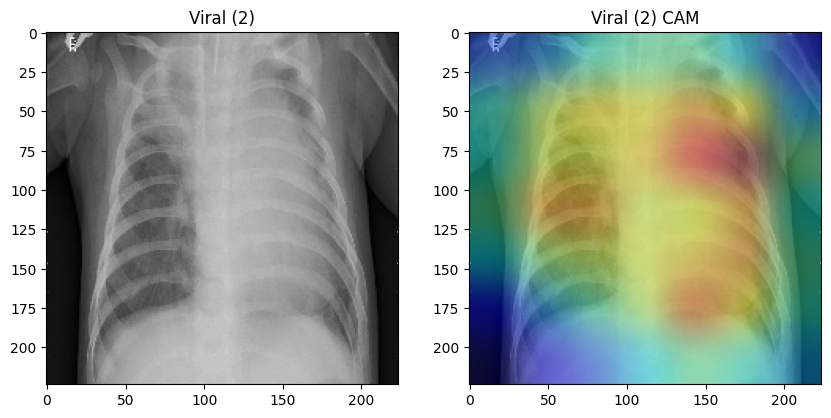

In [94]:
#plot Normal image with/without CLAHE
fig = plt.figure(figsize=(10, 10))
columns = 2 
rows = 1
fig.add_subplot(rows, columns, 1)
plt.title('Viral (2)')
plt.imshow(ressssss)

fig.add_subplot(rows, columns, 2)
plt.title('Viral (2) CAM')
plt.imshow(superimpose_gradcam(ressssss, res))
plt.show()